# Imports & Pre-processing

In [1]:
import sys
sys.path.append("../src")

from utils import *
from mitigation_fct import *
from distance import *
from Gems_Wasserstein import *

In [2]:
import pandas as pd
import torch
import torch.nn as nn
import schedulefree
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
from scipy import stats
from pandas.api.types import is_string_dtype

In [ ]:
df_all = pd.read_csv('../Data/BAF/Base_mod.csv')
result_path = '../Result/BAF/' #'../Result/BAF/' -> Prblm network's dict state save

In [4]:
target_name, S_variable_name_1, S_variable_name_2 = 'fraud_bool', 'income', 'customer_age'

In [5]:
X_col, dic_col_name_index = [], {}
for index, column in enumerate(df_all.columns):
    if column not in [target_name, S_variable_name_1, S_variable_name_2]:
        X_col.append(column)
    dic_col_name_index[column] = index

In [6]:
test_percentage = 0.2# 0.05
epochs, batch_size = 3, 2048
X = df_all[X_col].values
X_cr = (X - X.mean(axis = 0)) / (X.var(axis = 0) ** (1/2))
Y = df_all[target_name].values
S_1 = df_all[S_variable_name_1].values
S_2 = df_all[S_variable_name_2].values

test_size = int(len(X) * test_percentage)
train_size = len(X) - test_size
train_size

800000

In [7]:
seed = 1234
indexs = np.arange(len(X))
np.random.seed(seed)
np.random.shuffle(indexs)
X_cr_train, Y_train, S_1_train, S_2_train = X_cr[indexs[:train_size]], Y[indexs[:train_size]], S_1[indexs[:train_size]], S_2[indexs[:train_size]]
X_cr_test, Y_test, S_1_test, S_2_test    = X_cr[indexs[train_size:]], Y[indexs[train_size:]], S_1[indexs[train_size:]], S_2[indexs[train_size:]]

X_train, X_test, Y_train, Y_test = torch.from_numpy(X_cr_train.astype(np.float32)), torch.from_numpy(X_cr_test.astype(np.float32)), torch.from_numpy(Y_train.astype(np.float32)), torch.from_numpy(Y_test.astype(np.float32))
Y_train.mean(), Y_test.mean()

(tensor(0.0111), tensor(0.0106))

# NN training and DI

In [8]:
threshold = 0.5

if you want to have the save result as we had in our paper, skip this step and directly load the weights

In [9]:
model = Network(X_train.shape[1], activation_bool = True, n_nodes=1024, n_loop = 2)
optimizer = schedulefree.AdamWScheduleFree(model.parameters(), 
                                           lr=0.001) #torch.optim.AdamW(model.parameters(), lr = 0.001)
net_path = result_path + 'net_state_dic.pt'
'''
training_network_threshold(model, 
                           optimizer, 
                           threshold=threshold, 
                           X_train    = X_train,
                           Y_train    = Y_train,
                           X_test     = X_test,
                           Y_test     = Y_test,
                           epochs     = 1,
                           batch_size = batch_size,
                           )
torch.save(model.state_dict(), net_path)
'''

model = Network(X_train.shape[1], activation_bool = True, n_nodes=1024, n_loop = 2)
model.load_state_dict(torch.load(net_path, weights_only=True))
model.eval()

Network(
  (seq): Sequential(
    (0): BatchNorm1d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=42, out_features=1024, bias=True)
    (2): ReLU()
    (3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=1024, out_features=1024, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Linear(in_features=1024, out_features=1024, bias=True)
    (8): ReLU()
    (9): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Linear(in_features=1024, out_features=1, bias=True)
  )
  (activation): Sigmoid()
)

In [10]:
label = (Y_test > threshold)*1.
proba = model(X_test.float()).squeeze()
prob_threshold = np.quantile(proba.detach().numpy(),  1 - Y_train.mean()) - 1e-7
pred = ( proba > prob_threshold)*1.
acc = ( (pred == label)*1.).mean().item()
print(acc, pred.mean())

0.9812650084495544 tensor(0.0111)


age

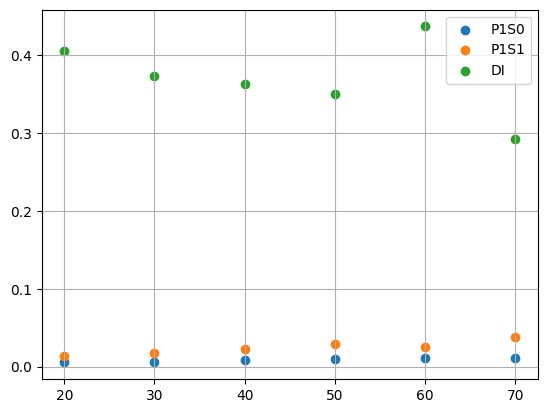

In [11]:
list_P1, list_P0, list_DI = [], [], []
for threshold in np.arange(20,80,10):
    P0, P1 = pred[S_2_test <= threshold].mean().item(), pred[S_2_test > threshold].mean().item()
    DI_value = P0 / P1
    list_P0.append(P0)
    list_P1.append(P1)
    list_DI.append(DI_value)
plt.scatter(np.arange(20,80,10), list_P0, label = 'P1S0')
plt.scatter(np.arange(20,80,10), list_P1, label = 'P1S1')
plt.scatter(np.arange(20,80,10), list_DI, label = 'DI')
plt.legend()
plt.grid()
plt.show()

We do see that the model predicts that older people are more likely considered to commit bank fraud

income

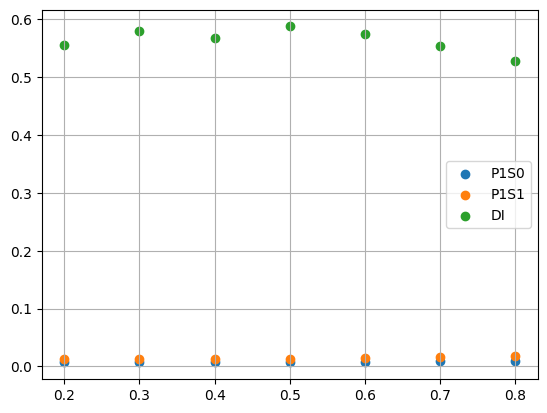

In [12]:
list_P1, list_P0, list_DI = [], [], []
for threshold in np.arange(0.2,0.9,0.1):
    P0, P1 = pred[S_1_test <= threshold].mean().item(), pred[S_1_test > threshold].mean().item()
    DI_value = P0 / P1
    list_P0.append(P0)
    list_P1.append(P1)
    list_DI.append(DI_value)
plt.scatter(np.arange(0.2,0.9,0.1), list_P0, label = 'P1S0')
plt.scatter(np.arange(0.2,0.9,0.1), list_P1, label = 'P1S1')
plt.scatter(np.arange(0.2,0.9,0.1), list_DI, label = 'DI')
plt.legend()
plt.grid()
plt.show()

The model predicts that richer people are more likely to commit bank fraud

We chose to concentrate on the case of the age being above or below 40

In [13]:
label = (Y_test > threshold)*1.
proba = model(X_test.float()).squeeze()
prob_threshold = np.quantile(proba.detach().numpy(),  1 - ((Y_train > threshold)*1.).mean()) - 1e-7
pred = ( proba > prob_threshold)*1.
#pred = (model(X_test.float()).squeeze() > 0.5)*1.
acc = ( (pred == label)*1.).mean().item()
number_expe = 20000
inputs, groups = X_test[:number_expe].clone(), (S_2_test > 40)[:number_expe]
DI = (pred[:number_expe][groups==0].mean() / pred[:number_expe][groups==1].mean()).item()
print(f'pred mean : {np.round(pred.mean().item(), 3)}, with an accuracy of {np.round(acc,3)}, and the Disparate Impact is {np.round(DI,3)}')

pred mean : 0.011, with an accuracy of 0.981, and the Disparate Impact is 0.347


# Mitigation

In [14]:
stresser = Stresser(X = inputs.float().numpy(), S = groups)

In [ ]:
stresser.W.DI_miti_grad(model,
                        prob_threshold = prob_threshold,
                        threshold = 0.8,
                        threshold_augm_constr = 0.005,
                        threshold_lr_cdt = 0.1,
                        iteration_threshold = 200,
                        look_alike = False,
                        verbose = True,
                        CONSTR_REGU = 4,
                        lr = 0.1,
                        delta_type = 'mean'
                        )
t_reg_me = stresser.W.t
stresser.W.DI_miti_grad(model,
                        prob_threshold = prob_threshold,
                        threshold = 0.8,
                        threshold_augm_constr = 0.005,
                        threshold_lr_cdt = 0.1,
                        iteration_threshold = 200,
                        look_alike = False,
                        verbose = False,
                        CONSTR_REGU = 4,
                        lr = 0.1,
                        delta_type = 'num'
                        )
t_reg_nu = stresser.W.t
stresser.W.DI_miti_grad(model,
                        prob_threshold = prob_threshold,
                        threshold = 0.8,
                        threshold_augm_constr = 0.005,
                        threshold_lr_cdt = 0.1,
                        iteration_threshold = 200,
                        look_alike = True,
                        verbose = False,
                        CONSTR_REGU = 4,
                        lr = 0.1,
                        delta_type = 'mean'
                        )
t_la_me = stresser.W.t
stresser.W.DI_miti_grad(model,
                        prob_threshold = prob_threshold,
                        threshold = 0.8,
                        threshold_augm_constr = 0.005,
                        threshold_lr_cdt = 0.1,
                        iteration_threshold = 200,
                        look_alike = True,
                        verbose = False,
                        CONSTR_REGU = 4,
                        lr = 0.1,
                        delta_type = 'num'
                        )
t_la_nu = stresser.W.t

P(Y=1|S=0) = 0.0081, P(Y=1|S=1) = 0.0233
former DI is 0.347, we thus have a difference of 0.453 to mitigate
We want to change it to new_P(Y=1|S=0) = 0.0139, and new_P(Y=1|S=1) = 0.0174
0.005912591550406417 0.7481561403447498
the starting mean is 0.0, we are 0.006 away
Thus the direction is 1.0

0
the former constraint was equal to 0.00591, the new is 0.00579
the regularization constraint increased to 0.36
the contraint value is 0.00579
the euclidian distance between is 0.0, 

1
the former constraint was equal to 0.00579, the new is 0.00585
the regularization constraint increased to 0.432
the contraint value is 0.00585
the euclidian distance between is 0.0, 

2
the former constraint was equal to 0.00585, the new is 0.00579
the regularization constraint increased to 0.5184
the contraint value is 0.00579
the euclidian distance between is 0.0, 

3
the former constraint was equal to 0.00579, the new is 0.00585
the regularization constraint increased to 0.62208
the contraint value is 0.00585

In [18]:
pred_ori = (model(torch.tensor(stresser.X).type(torch.float32)) > prob_threshold)*1.

tensor_reg_me = (torch.from_numpy(t_reg_me + stresser.X)).type(torch.float32)
pred_reg_me = (model(tensor_reg_me) > prob_threshold)*1.

tensor_reg_nu = (torch.from_numpy(t_reg_nu + stresser.X)).type(torch.float32)
pred_reg_nu = (model(tensor_reg_nu) > prob_threshold)*1.

tensor_la_me = (torch.from_numpy(t_la_me + stresser.X)).type(torch.float32)
pred_la_me = (model(tensor_la_me) > prob_threshold)*1.

tensor_la_nu = (torch.from_numpy(t_la_nu + stresser.X)).type(torch.float32)
pred_la_nu = (model(tensor_la_nu) > prob_threshold)*1.

In [19]:
arr_start       = np.concatenate([stresser.X, stresser.S.reshape(number_expe, -1), pred_ori], axis = 1)

arr_grad_reg_me = np.concatenate([stresser.X + t_reg_me, stresser.S.reshape(number_expe, -1), pred_reg_me], axis = 1)
arr_grad_reg_nu = np.concatenate([stresser.X + t_reg_nu, stresser.S.reshape(number_expe, -1), pred_reg_nu], axis = 1)

arr_grad_la_me  = np.concatenate([stresser.X + t_la_me, stresser.S.reshape(number_expe, -1), pred_la_me], axis = 1)
arr_grad_la_nu  = np.concatenate([stresser.X + t_la_nu, stresser.S.reshape(number_expe, -1), pred_la_nu], axis = 1)

In [20]:
new_arr_mod_SF, bins, translation = find_translation_DI(arr = arr_start,
                    S_index = -2,
                    Y_index = -1,
                    threshold = 0.8,
                    speed = 1,
                    bool_return_all = True,
                    verbose = False
                    )

In [21]:
new_arr, swaps, dic_number_swap_done, wass_distance = find_sampling_wasserstein_DI(arr = arr_start,
                                                                                   S_index = -2, #dic_col_name_index[dic_file[file_obj]['S_variable_name']],
                                                                                   Y_index = -1, #dic_col_name_index[dic_file[file_obj]['target_name']],
                                                                                   verbose = True,
                                                                                   )

0.34668105774419855
0.3533473997512894
0.36017258859312
0.36716243607125115
0.3743230409897077
0.3816608070926322
0.3891824623642932
0.3968950798137079
0.40480609987884714
0.41292335459959273
0.4212550937245314
0.4298100129345163
0.43859728438597284
0.44762658979947983
0.4569081563445695
0.4664527956003666
0.4762719459041101
0.48637771843630834
0.49678294743292334
0.5075012449622994
0.518547060758423
0.5299357476635513
0.541683633303472
0.5538080986990778
0.5663276646102277
0.5792620865139949
0.5926324592417179
0.6028502602631269
0.6171010049395333
0.6281206657420249
0.6433463959413404
0.6591333075550672
0.6755131660792038
0.6925201805093142
0.7101912428993084
0.7285661966672771
0.747688137755102
0.767603753433018
0.7839357481869119


In [22]:
arr_miti_gems_KL_number = Gems_fair_mitigation_arr(arr=arr_start, 
                                                   S_column_index = -2,
                                                   Pred_column_index = -1, 
                                                   Y_column_index = None,
                                                   DI_target = 0.8,
                                                   delta_type = 'number')

arr_miti_gems_KL_mean = Gems_fair_mitigation_arr(arr=arr_start, 
                                                 S_column_index = -2,
                                                 Pred_column_index = -1, 
                                                 Y_column_index = None,
                                                 DI_target = 0.8,
                                                 delta_type = 'mean')

In [ ]:
np.save(file = result_path + 'DI.npy',
        arr  = DI)
np.save(file = result_path + 'X_number_column.npy',
        arr  = X_train.shape[1])
np.save(file = result_path + 'threshold.npy',
        arr  = prob_threshold)
np.save(file = result_path + 'original.npy', 
        arr = arr_start)

np.save(file = result_path + 'Grad_reg_me.npy',
        arr = arr_grad_reg_me)
np.save(file = result_path + 'Grad_reg_nu.npy',
        arr = arr_grad_reg_nu)
np.save(file = result_path + 'Grad_la_me.npy',
        arr = arr_grad_la_me)
np.save(file = result_path + 'Grad_la_nu.npy',
        arr = arr_grad_la_nu)


np.save(file = result_path + 'Miti_sampling_X.npy', 
        arr = new_arr)
np.save(file = result_path + 'Miti_mod_SF.npy', 
        arr = new_arr_mod_SF)
np.save(file = result_path + 'Miti_Gems_number.npy', 
        arr = arr_miti_gems_KL_number)
np.save(file = result_path + 'Miti_Gems_mean.npy', 
        arr = arr_miti_gems_KL_mean)